# Урок 6. Градиентный бустинг. AdaBoost

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

### Task 1. 
Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

### Реализация алгоритма градиентного бустинга<a class='anchor' id='implement'>

In [2]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [3]:
def gb_predict(X, trees_list, eta):
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [4]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [5]:
def residual(y, z):
    return - (z - y)

In [59]:
def gb_fit(X_train, X_test, y_train, y_test, n_trees = 1, max_depth = 1, eta = 0.1):
    
    trees = []
    train_errors = []
    test_errors = []
    

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)


        if len(trees) == 0:
            tree.fit(X_train, y_train)

            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:

            target = gb_predict(X_train, trees, eta)


            tree.fit(X_train, residual(y_train, target))

            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)

    return trees, train_errors, test_errors

In [12]:
# визуализация
def get_error_plot(train_err, test_err,n_trees):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.grid()
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

### Зависимость ошибки от кол-ва деревьев

In [60]:
trees, train_errors, test_errors = gb_fit(X_train, X_test, y_train, y_test, n_trees = 100, max_depth = 3, eta = 0.1)

In [63]:
len(train_errors)

100

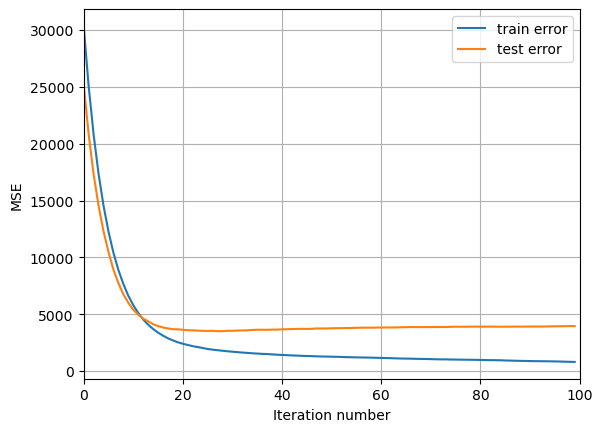

In [62]:
get_error_plot(train_errors, test_errors, n_trees= 100)

<b> Ответ:</b> таким образом, с увеличением кол-ва деревьев MSE падает: сначала резко, потом плавнее.

### Зависимость ошибки от глубины деревьев

Сперва немного подправим код бустинга, чтобы max_depth принимал список значей, которых он будет уже итерировать

In [65]:
def gb1_fit(X_train, X_test, y_train, y_test, n_trees = 1, max_depth = [], eta = 0.1):
    
    result ={}
    
    for depth in max_depth:
        
        trees = []
        train_errors = []
        test_errors = []
        
        for i in range(n_trees):
            tree = DecisionTreeRegressor(max_depth=depth, random_state=42)


            if len(trees) == 0:
                tree.fit(X_train, y_train)

                train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
                test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
            else:

                target = gb_predict(X_train, trees, eta)


                tree.fit(X_train, residual(y_train, target))

                train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
                test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

            trees.append(tree)
        result[f'{depth}']= [train_errors,test_errors]
    return result, n_trees

In [66]:
result, n_trees = gb1_fit(X_train, X_test, y_train, y_test, n_trees = 10, max_depth = [2,3,4,5], eta = 0.1)

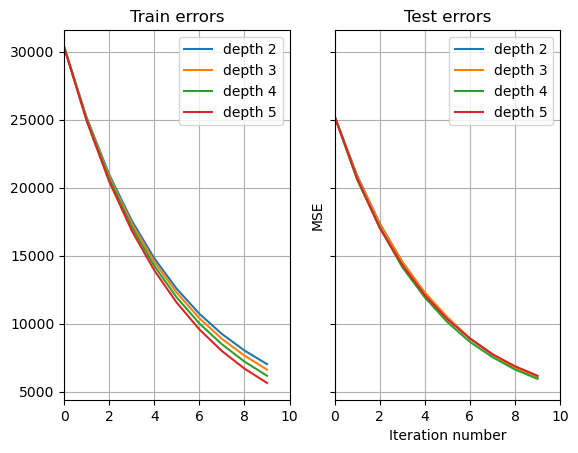

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex= True , sharey= True)

ax1.plot(list(range(n_trees)), result['2'][0], label='depth 2')
ax1.plot(list(range(n_trees)), result['3'][0], label='depth 3')
ax1.plot(list(range(n_trees)), result['4'][0], label='depth 4')
ax1.plot(list(range(n_trees)), result['5'][0], label='depth 5')
ax1.set_title("Train errors")
ax1.legend(loc='upper right')
ax1.grid()

ax2.plot(list(range(n_trees)), result['2'][1], label='depth 2')
ax2.plot(list(range(n_trees)), result['3'][1], label='depth 3')
ax2.plot(list(range(n_trees)), result['4'][1], label='depth 4')
ax2.plot(list(range(n_trees)), result['5'][1], label='depth 5')
ax2.set_title("Test errors")
ax2.legend(loc='upper right')
ax2.grid()

plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.show()

<b> Ответ:</b> На тренировочной выборке видно, как с увеличением глубины возрастает и скорость уменьшения ошибки, на тестовой выборке всё не так очевидно.

### Task 2. 
Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [96]:
def stoch_gb_fit(X_train, X_test, y_train, y_test, n_trees = 1, max_depth = 1, eta = 0.1, batch = 1):
    
    trees = []
    train_errors = []
    test_errors = []
    
    
    for i in range(n_trees):
        #выбираем случайные элементы(индексы) из выборки
        train_ind = np.random.randint(X_train.shape[0], size = batch)
        
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

            
        if len(trees) == 0:
            tree.fit(X_train[train_ind], y_train[train_ind])

            train_errors.append(mean_squared_error(y_train[train_ind], gb_predict(X_train[train_ind], trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
               
            target = gb_predict(X_train[train_ind], trees, eta)

             
            tree.fit(X_train[train_ind], residual(y_train[train_ind], target))

            train_errors.append(mean_squared_error(y_train[train_ind], gb_predict(X_train[train_ind], trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors, n_trees

In [107]:
# визуализация
def error_plot(test_err,n_trees):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.grid()
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [111]:
trees, train_errors, test_errors, n_trees = stoch_gb_fit(X_train, X_test, y_train, y_test, n_trees = 70, max_depth = 3, eta = 0.1, batch = 35)

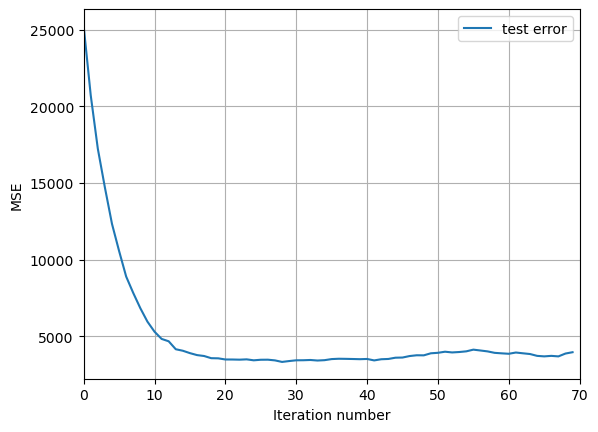

In [112]:
error_plot(test_errors,n_trees)

<b> Ответ:</b> видно, что в основном ошибка падает, показывая незначительные флуктуации в своём плато.